# Using the Oxygen ML Model

In [1]:
%cd ..

/home/rehak/repos/ops/ecris.analysis


# Training the model

If you need to create a model, there is a straightforward function for doing so. 

**This can then be saved as a `pkl` file and loaded in the future instead of retraining.**

In [13]:
from ops.ecris.analysis.csd.ml import train_oxygen_model
import joblib
from pathlib import Path

MODEL_DIR = Path('./models/oxygen_nn')
model_path = MODEL_DIR / 'mlp_csd_oxygen.pkl'

training = False
save = False

if training:
    parameters = MODEL_DIR / 'mlp_csd_oxygen_params.json'
    x_path = MODEL_DIR / 'x_training.npy'
    y_path = MODEL_DIR / 'y_training.npy'
    pipeline = train_oxygen_model(parameters, x_path, y_path)
    if save:
        joblib.dump(pipeline, model_path)
    pipeline

# Using the model

Now we will load the model and a random CSD.

In [14]:
import random

from ops.ecris.analysis.io import read_csd_from_file_pair
from ops.ecris.analysis.csd import estimate_m_over_q, rescale_m_over_q
from ops.ecris.analysis.csd.ml import find_oxygen_peaks

CSD_FILEPATHS = list(Path('./data/csds').glob('csd_*'))
FILE_NUM = random.randint(0, len(CSD_FILEPATHS))
model = joblib.load(model_path)
csd_file = CSD_FILEPATHS[FILE_NUM] 
csd = read_csd_from_file_pair(csd_file)
print(f'Loaded CSD file: {csd_file}')

Loaded CSD file: data/csds/csd_1750809936


We will use the model to find the oxygen peaks and rescale M/Q. If peaks cannot be found, it will raise a `RuntimeError`.

In [17]:
csd.m_over_q = estimate_m_over_q(csd)
try:
    ml_peaks, probability = find_oxygen_peaks(csd, model)
    csd.m_over_q = rescale_m_over_q(csd.m_over_q, ml_peaks)
    print(f'Peaks found with {probability=}')
except RuntimeError as exc:
    print(f'Peaks not found, {exc}')


Peaks found with probability=0.8982225286310243


Plot the CSD and the peaks.

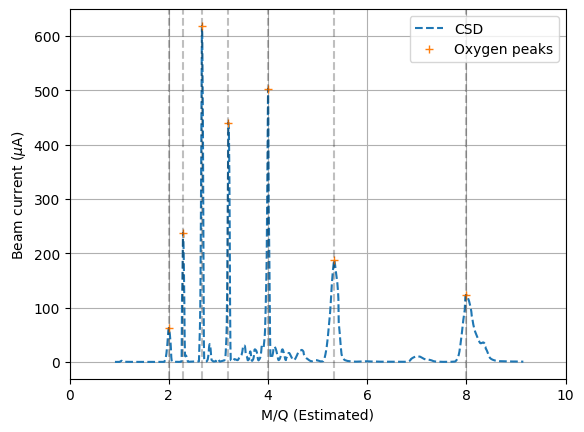

In [21]:
import matplotlib.pyplot as plt
plt.plot(csd.m_over_q, csd.beam_current, '--', label='CSD')
plt.plot(ml_peaks.m_over_q, ml_peaks.beam_current, '+', label='Oxygen peaks')
for i in range(1, 9):
    plt.axvline(16/i, ls='--', alpha=0.25, c='k')
plt.xlabel('M/Q (Estimated)')
plt.ylabel(r'Beam current ($\mu$A)')
plt.xlim([0,10])
plt.grid()
plt.legend()
plt.show()